# Disclaimer: This code is inspired by Deeplab tutorial

In [1]:
#To block unnecessary tensoflow warnings
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
import pylab
import tensorflow as tf
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
import matplotlib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
import skimage
import copy
import skimage.segmentation
import scipy.misc

In [3]:
class myDeep(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read()) 
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)
        #show graph nodes
        for n in tf.get_default_graph().as_graph_def().node:
              print('name',n.name) 
        writer = tf.summary.FileWriter('./log/', self.sess.graph)      

    

    def inference(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
      
        #retrieve original image size
        width, height = image.size
        #Model trained on Cityscapes images with size (2049,1025)
        target_size = (2049,1025)  
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        print('resized_image',resized_image)
        batch_seg_map = self.sess.run(OUTPUT_TENSOR_NAME,feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        print('input', np.asarray(resized_image).shape) #(1025,2049,3)
        #print('batch :',batch_seg_map)
        seg_map = batch_seg_map[0]  # expected batch size = 1
        #resize segmented image to reove filter effect
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

    def create_label_colormap(self):
        colormap = np.array([
        [100,  125, 128],
        [125,  15, 232],
        [ 120,  10,  100],
        [102, 100, 156],
        [190, 153, 153],
        [125, 0, 153],
        [250, 170,  30],
        [250, 210,   0],
        [120, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
        return colormap

    #Mapper function 
    def mapper(self,label):

      if label.ndim != 2:
        raise ValueError('Expect 2-D input label')
      colormap = self.create_label_colormap()
      if np.max(label) >= len(colormap):
        print('label',np.max(label))
        raise ValueError('label value too large.')
      return colormap[label]

 
    #plot function
    def plot_segmentation(self,image, seg_map):
   
     plt.figure(figsize=(20, 4))
     grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])
     #plot the input image 
     plt.subplot(grid_spec[0])
     plt.imshow(image)
     plt.axis('off')
     plt.title('Original image')
    
     plt.subplot(grid_spec[1])
     seg_image = self.mapper(seg_map).astype(np.uint8)
     print('seg_image',seg_image)
     print(seg_image.shape)
     plt.imshow(seg_image)
     plt.axis('off')
     plt.title('segmentation map')
        
     plt.subplot(grid_spec[2])
     plt.imshow(image)
     plt.imshow(seg_image, alpha=0.7)
     plt.axis('off')
     plt.title('segmentation overlay')
    
     LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])
     FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
     print('FULL_LABEL_MAP: ',FULL_LABEL_MAP)
     FULL_COLOR_MAP = self.mapper(FULL_LABEL_MAP)
     unique_labels = np.unique(seg_map)
     ax = plt.subplot(grid_spec[3])
     #print(FULL_COLOR_MAP[unique_labels])
     plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
     ax.yaxis.tick_right()
     plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
     plt.xticks([], [])
     ax.tick_params(width=0.0)
     plt.grid('off')
     plt.show()
        

In [4]:
MODEL_NAME =  'mobilenetv2_coco_cityscapes_trainfine'
#link to the tensorflow models 
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'
#create temporary file 
model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)
download_path = os.path.join(model_dir, _TARBALL_NAME)
print(download_path)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')
MODEL = myDeep(download_path)
print('model loaded successfully!')

/var/folders/jk/xgzg12hn22zg4ykr4zh91d280000gn/T/tmpzfdvawza/deeplab_model.tar.gz
downloading model, this might take a while...
http://download.tensorflow.org/models/deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz /var/folders/jk/xgzg12hn22zg4ykr4zh91d280000gn/T/tmpzfdvawza/deeplab_model.tar.gz
download completed! loading DeepLab model...
model loaded successfully!


In [5]:
Xi=urllib.request.urlretrieve('https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg')[0]


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x523 at 0x130550EB8>
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1346A9470>
input (1025, 2049, 3)
seg_map [[ 2  2  2 ...  0 10 10]
 [ 2  2  2 ...  0 10  2]
 [ 2  2  2 ...  0  0  2]
 ...
 [ 2  2  0 ...  0  0  0]
 [ 2  2  2 ...  0  0  0]
 [ 2  2  2 ...  1  0  0]]
seg_map_shape (523, 500)
seg_image [[[120  10 100]
  [120  10 100]
  [120  10 100]
  ...
  [100 125 128]
  [ 70 130 180]
  [ 70 130 180]]

 [[120  10 100]
  [120  10 100]
  [120  10 100]
  ...
  [100 125 128]
  [ 70 130 180]
  [120  10 100]]

 [[120  10 100]
  [120  10 100]
  [120  10 100]
  ...
  [100 125 128]
  [100 125 128]
  [120  10 100]]

 ...

 [[120  10 100]
  [120  10 100]
  [100 125 128]
  ...
  [100 125 128]
  [100 125 128]
  [100 125 128]]

 [[120  10 100]
  [120  10 100]
  [120  10 100]
  ...
  [100 125 128]
  [100 125 128]
  [100 125 128]]

 [[120  10 100]
  [120  10 100]
  [120  10 100]
  ...
  [125  15 232]
  [100 125 128]
  [100 125 

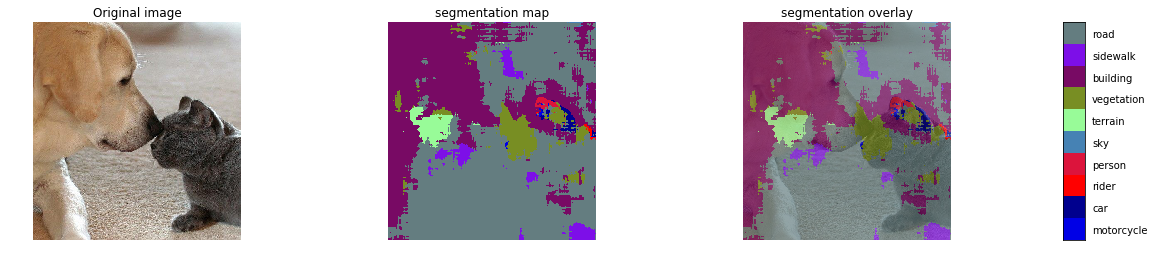

In [6]:
# Call the class 
def Result_segmentation(SAMPLE_IMAGE):
   # """Inferences DeepLab model and visualizes result."""
     original_im = Image.open(SAMPLE_IMAGE)
     print(original_im)
     seg_map = MODEL.inference(original_im)
     print('seg_map',seg_map)
     print('seg_map_shape',seg_map.shape)
     MODEL.plot_segmentation(original_im, seg_map)
Result_segmentation(Xi) 

[1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1
 1 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1]


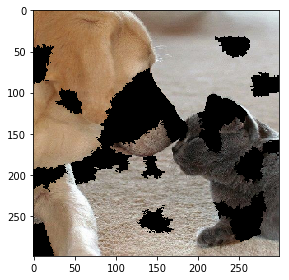

In [7]:
#Generating simple LIME Perturbaion
Xi = skimage.io.imread("https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
Xi = skimage.transform.resize(Xi, (299,299)) 
Xi = (Xi - 0.5)*2


#Generate segmentation for image
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

#Generate perturbations
num_perturb =10
perturbations = np.random.binomial(1, 0.8, size=(num_perturb, num_superpixels))

#Create function to apply perturbations to images
def perturb_image(img,perturbation,segments): 
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  scipy.misc.imsave("Xi.jpg", perturbed_image)
  return perturbed_image




#Show example of perturbations
print(perturbations[0]) 
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))
plt.show()

In [8]:
Xi='/Users/hormone03/Desktop/Neurocast/Xi.jpg'

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=299x299 at 0x1349EA080>
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1306D4860>
input (1025, 2049, 3)
seg_map [[ 2  2  2 ... 10 10 10]
 [ 2  2  2 ... 10 10 10]
 [ 2  2  2 ... 10 10 10]
 ...
 [11 11 11 ...  0  1  1]
 [11 11 11 ...  0  1  1]
 [11 11 11 ...  0  1  1]]
seg_map_shape (299, 299)
seg_image [[[120  10 100]
  [120  10 100]
  [120  10 100]
  ...
  [ 70 130 180]
  [ 70 130 180]
  [ 70 130 180]]

 [[120  10 100]
  [120  10 100]
  [120  10 100]
  ...
  [ 70 130 180]
  [ 70 130 180]
  [ 70 130 180]]

 [[120  10 100]
  [120  10 100]
  [120  10 100]
  ...
  [ 70 130 180]
  [ 70 130 180]
  [ 70 130 180]]

 ...

 [[220  20  60]
  [220  20  60]
  [220  20  60]
  ...
  [100 125 128]
  [125  15 232]
  [125  15 232]]

 [[220  20  60]
  [220  20  60]
  [220  20  60]
  ...
  [100 125 128]
  [125  15 232]
  [125  15 232]]

 [[220  20  60]
  [220  20  60]
  [220  20  60]
  ...
  [100 125 128]
  [125  15 232]
  [125  15 

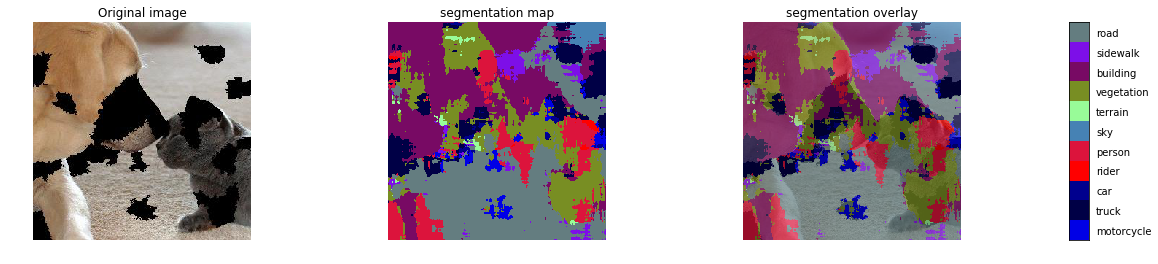

In [9]:
#Testing model after image perturbation
Result_segmentation(Xi) 

In [13]:
import get_dataset_colormap


## Webcam demo

cap = cv.VideoCapture(0)

# Next line may need adjusting depending on webcam resolution
final = np.zeros((1, 384, 1026, 3))
while True:
    ret, frame = cap.read()
    
    # From cv2 to PIL
    cv2_im = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    pil_im = Image.fromarray(cv2_im)
    
    # Run model
    seg_map = MODEL.inference(pil_im)
    
    # Adjust color of mask
    seg_image = get_dataset_colormap.label_to_color_image(
        seg_map, get_dataset_colormap.get_pascal_name()).astype(np.uint8)
    
    # Convert PIL image back to cv2 and resize
    frame = np.array(pil_im)
    r = seg_image.shape[1] / frame.shape[1]
    dim = (int(frame.shape[0] * r), seg_image.shape[1])[::-1]
    resized = cv.resize(frame, dim, interpolation = cv.INTER_AREA)
    resized = cv.cvtColor(resized, cv.COLOR_RGB2BGR)
    
    # Stack horizontally color frame and mask
    color_and_mask = np.hstack((resized, seg_image))

    cv.imshow('frame', color_and_mask)
    if cv.waitKey(25) & 0xFF == ord('q'):
        cap.release()
        cv.destroyAllWindows()
        break

    
###  UNCOMMENT NEXT LINES TO SAVE THE VIDEO  ###
    output = np.expand_dims(color_and_mask, axis=0)
    #final = np.append(final, output, 0)
    #final = np.zeros((1, 384, 1026, 3))
    final = final[::5,...]

skvideo.io.vwrite("outputvideo111.mp4", final)

resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1349F9320>
input (1025, 2049, 3)
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1349F94A8>
input (1025, 2049, 3)
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1349F9320>
input (1025, 2049, 3)
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1349F94A8>
input (1025, 2049, 3)
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1349F9320>
input (1025, 2049, 3)
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1349F94A8>
input (1025, 2049, 3)
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1349F9320>
input (1025, 2049, 3)
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1349F94A8>
input (1025, 2049, 3)
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x1349F9320>
input (1025, 2049, 3)
resized_image <PIL.Image.Image image mode=RGB size=2049x1025 at 0x131A9E128>
input (1025, 2049, 3)
resized_im

input (1025, 2049, 3)


KeyboardInterrupt: 